In [1]:
import os
import numpy as np
import random
import time
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
from collections import Counter

# Set GPU as the default device
device = 'gpu:0' if tf.config.list_physical_devices('GPU') else 'cpu'

In [2]:
# Define constants
FILE_PATH = os.path.abspath(os.getcwd())
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50
MIN_IMAGES = 700
DATASET_PATH = os.path.join(FILE_PATH, 'data/dresden')

C:\Users\aa204\AppData\Local\Temp\ipykernel_16240\521286455.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette=colors)


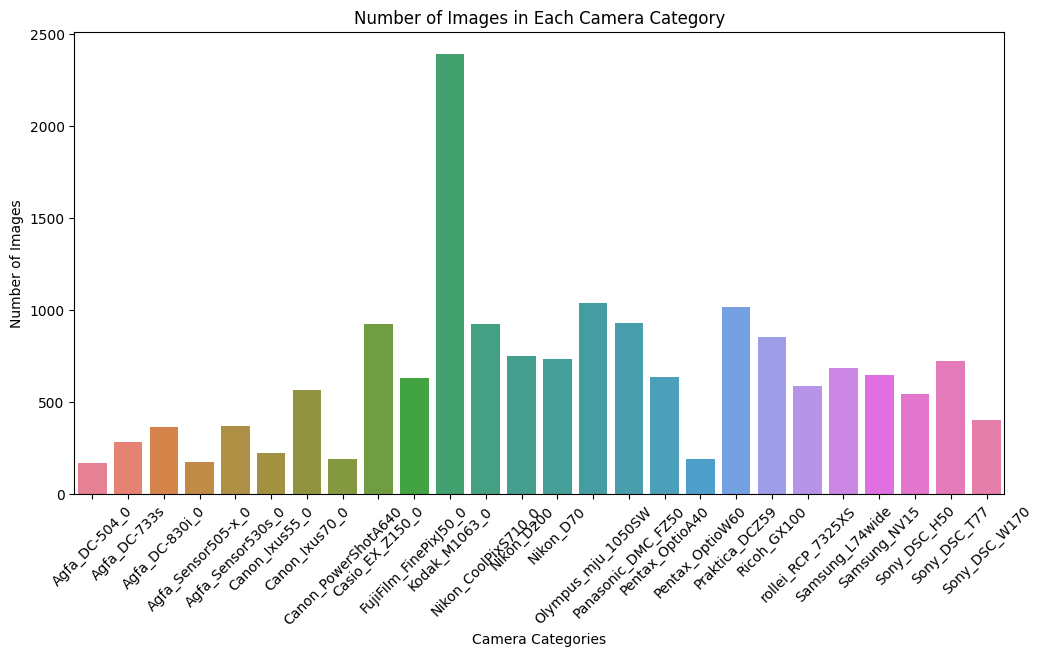

In [3]:
# Step 1: EDA - Visualize the number of images in each camera category
def visualize_class_distribution(dataset_path):
    class_counts = {}
    for camera_folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, camera_folder)
        if os.path.isdir(folder_path):
            class_counts[camera_folder] = len(os.listdir(folder_path))

    plt.figure(figsize=(12, 6))
    colors = sns.color_palette('husl', len(class_counts))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette=colors)
    plt.title('Number of Images in Each Camera Category')
    plt.xlabel('Camera Categories')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()

# Run EDA
visualize_class_distribution(DATASET_PATH)

In [4]:
# Step 2: Filter and copy camera folders with more than 700 images

FILTERED_DATASET_PATH = os.path.join(FILE_PATH, 'data/filtered_dresden')

if not os.path.exists(FILTERED_DATASET_PATH):
    os.makedirs(FILTERED_DATASET_PATH)

for camera_folder in tqdm(os.listdir(DATASET_PATH), desc="Filtering camera folders"):
    folder_path = os.path.join(DATASET_PATH, camera_folder)
    images = os.listdir(folder_path)

    if len(images) >= MIN_IMAGES:
        filtered_folder_path = os.path.join(FILTERED_DATASET_PATH, camera_folder)
        os.makedirs(filtered_folder_path, exist_ok=True)
        for image in tqdm(images, desc=f"Copying images from {camera_folder}", leave=False):
            src = os.path.join(folder_path, image)
            dest = os.path.join(filtered_folder_path, image)
            if not os.path.exists(dest):
                shutil.copy(src, dest)
    else:
        time.sleep(0.1)
        

# Step 3: Load dataset with filtered folders
NUM_CLASSES = len(os.listdir(FILTERED_DATASET_PATH))


Filtering camera folders: 100%|██████████| 26/26 [00:02<00:00, 12.73it/s]


C:\Users\aa204\AppData\Local\Temp\ipykernel_16240\521286455.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette=colors)


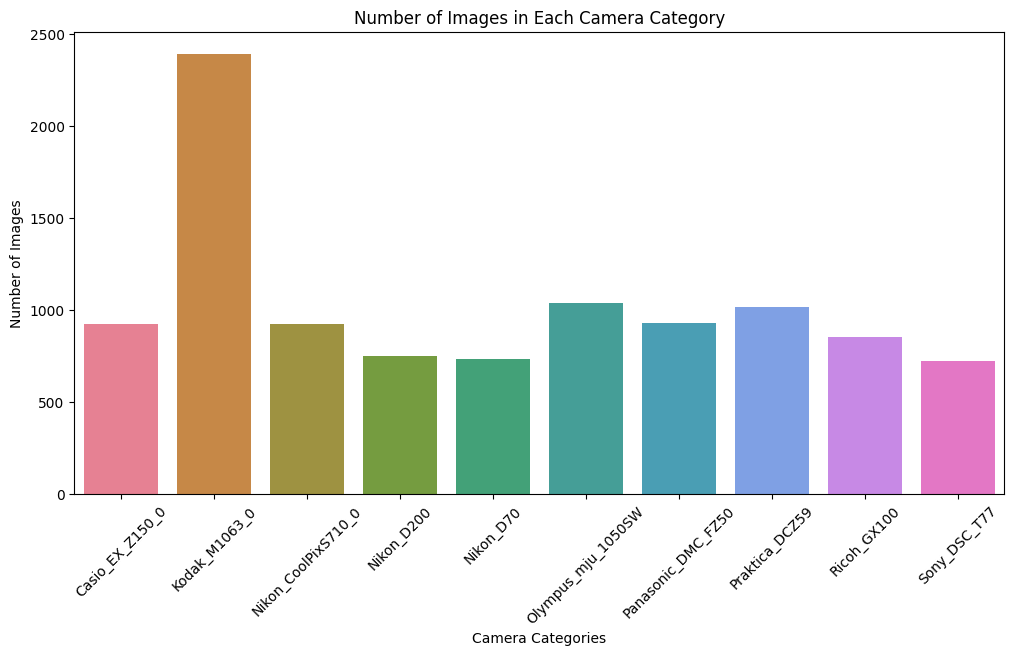

In [5]:
# Step 3: Analyze distribution of images in filtered dataset
NUM_CLASSES = len(os.listdir(FILTERED_DATASET_PATH))

visualize_class_distribution(FILTERED_DATASET_PATH)


In [6]:


# Function to oversample underrepresented classes
def oversample_generator(directory, datagen, target_size, batch_size, class_mode, subset):
    # Get class counts
    class_counts = Counter([subdir for subdir in os.listdir(directory) if os.path.isdir(os.path.join(directory, subdir))])
    max_count = max(class_counts.values())

    # Create a list of file paths and labels
    file_paths = []
    labels = []
    for class_label, count in class_counts.items():
        class_dir = os.path.join(directory, class_label)
        images = os.listdir(class_dir)
        file_paths.extend([os.path.join(class_dir, img) for img in images])
        labels.extend([class_label] * len(images))

        # Oversample by adding rotated images
        if count < max_count:
            for _ in range(max_count - count):
                img_path = random.choice(images)
                img = load_img(os.path.join(class_dir, img_path), target_size=target_size)
                img_array = img_to_array(img)
                img_array = datagen.random_transform(img_array)
                file_paths.append(os.path.join(class_dir, img_path))
                labels.append(class_label)

    # Create a generator from the oversampled data
    return datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': file_paths, 'class': labels}),
        directory=None,
        x_col='filename',
        y_col='class',
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode,
        subset=subset,
        shuffle=True
    )

# Define the data generator with augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = oversample_generator(
    FILTERED_DATASET_PATH,
    datagen,
    IMAGE_SIZE,
    BATCH_SIZE,
    'categorical',
    'training'
)

validation_generator = datagen.flow_from_directory(
    FILTERED_DATASET_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 8239 validated image filenames belonging to 10 classes.
Found 2057 images belonging to 10 classes.


In [7]:
# Step 5: Define a Imagenet based model

def create_model_with_fc_layers(num_classes, input_shape):
    inputs = Input(shape=input_shape)

    # First convolutional block
    x = Conv2D(64, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)

    # Second convolutional block with residual connection
    residual = Conv2D(128, (3, 3), padding='same')(x)
    residual = BatchNormalization()(residual)
    residual = ReLU()(residual)
    residual = Conv2D(128, (3, 3), padding='same')(residual)
    residual = BatchNormalization()(residual)
    shortcut = Conv2D(128, (1, 1), padding='same')(x)  # Match dimensions
    x = ReLU()(residual + shortcut)
    x = MaxPooling2D((2, 2))(x)

    # Third convolutional block with residual connection
    residual = Conv2D(256, (3, 3), padding='same')(x)
    residual = BatchNormalization()(residual)
    residual = ReLU()(residual)
    residual = Conv2D(256, (3, 3), padding='same')(residual)
    residual = BatchNormalization()(residual)
    shortcut = Conv2D(256, (1, 1), padding='same')(x)  # Match dimensions
    x = ReLU()(residual + shortcut)
    x = MaxPooling2D((2, 2))(x)

    # Global average pooling and fully connected layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = Model(inputs=inputs, outputs=output)

    # Compile the model
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

with tf.device(device):
    # Create the model
    model = create_model_with_fc_layers(NUM_CLASSES, IMAGE_SIZE + (3,))

    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        min_delta=0.001,
        restore_best_weights=True
    )

    # Print the model summary
    model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [8]:
with tf.device(device):
    # Train the model
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=validation_generator,
        callbacks=[early_stopping]
    )

    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(validation_generator)
    print(f'Validation Accuracy: {val_accuracy*100:.2f}%')

Epoch 1/50
258/258 [==============================] - 488s 2s/step - loss: 2.0515 - accuracy: 0.2251 - val_loss: 3.3172 - val_accuracy: 0.1303
Epoch 2/50
258/258 [==============================] - 470s 2s/step - loss: 1.7784 - accuracy: 0.3384 - val_loss: 6.0687 - val_accuracy: 0.1317
Epoch 3/50
258/258 [==============================] - 477s 2s/step - loss: 1.6313 - accuracy: 0.3965 - val_loss: 2.6877 - val_accuracy: 0.3359
Epoch 4/50
258/258 [==============================] - 476s 2s/step - loss: 1.4873 - accuracy: 0.4548 - val_loss: 2.3741 - val_accuracy: 0.4409
Epoch 5/50
258/258 [==============================] - 475s 2s/step - loss: 1.3543 - accuracy: 0.5055 - val_loss: 2.8387 - val_accuracy: 0.3802
Epoch 6/50
258/258 [==============================] - 474s 2s/step - loss: 1.2553 - accuracy: 0.5379 - val_loss: 2.2795 - val_accuracy: 0.5586
Epoch 7/50
258/258 [==============================] - 472s 2s/step - loss: 1.1577 - accuracy: 0.5813 - val_loss: 2.6332 - val_accuracy: 0.4570

Total Epochs Completed (Early Stopping): 38
Final Training Loss: 0.2262
Final Validation Loss: 1.8841
Final Training Accuracy: 92.39%
Final Validation Accuracy: 81.19%


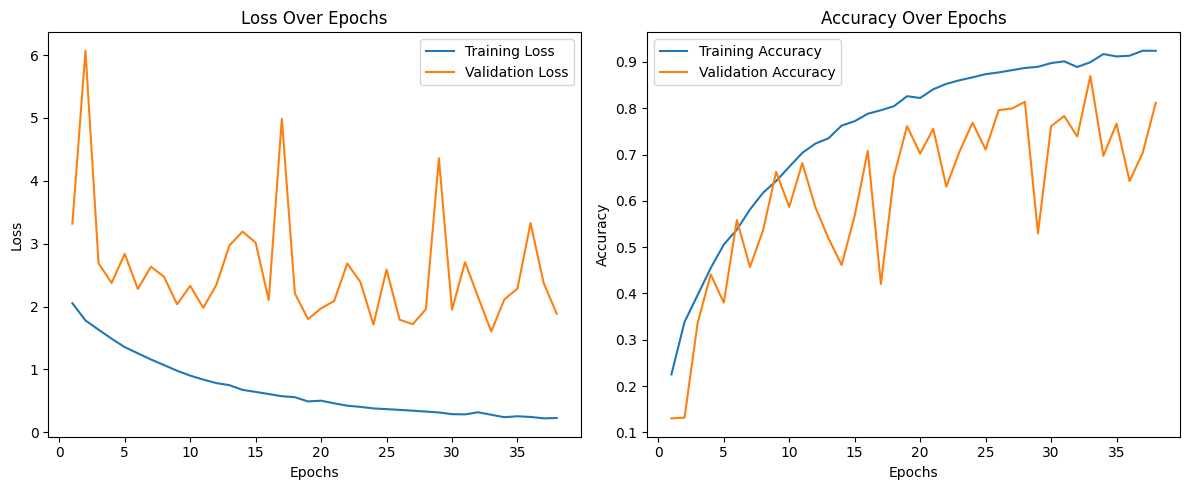

In [9]:
# Extract and plot training history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Number of epochs completed
epochs_completed = len(training_loss)
print(f'Total Epochs Completed (Early Stopping): {epochs_completed}')
print(f'Final Training Loss: {training_loss[-1]:.4f}')
print(f'Final Validation Loss: {validation_loss[-1]:.4f}')
print(f'Final Training Accuracy: {training_accuracy[-1]*100:.2f}%')
print(f'Final Validation Accuracy: {validation_accuracy[-1]*100:.2f}%')

# Plot Loss and Accuracy Graphs
plt.figure(figsize=(12, 5))

# Loss Graph
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs_completed + 1), training_loss, label='Training Loss')
plt.plot(range(1, epochs_completed + 1), validation_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Graph
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs_completed + 1), training_accuracy, label='Training Accuracy')
plt.plot(range(1, epochs_completed + 1), validation_accuracy, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Save the final model
model.save('camera_identification_model_bagnet.keras')

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Assuming model is trained, and test_data is prepared
# `test_data` is a tf.data.Dataset or similar with batches of test images and labels

# Step 1: Generate predictions and true labels
y_pred = []
y_true = []

for images, labels in test_data:
    predictions = model.predict(images)  # Get model predictions
    y_pred.extend(np.argmax(predictions, axis=1))  # Predicted classes
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # True classes

# Step 2: Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Step 3: Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Optional: Classification report for more metrics
print("Classification Report:\n", classification_report(y_true, y_pred))


NameError: name 'test_data' is not defined